# Differential Diagnosis of COVID-19 with Bayesian Belief Networks

Let's see if a Bayesian Belief Network (`BBN`) is able to diagnose the COVID-19 virus with any reasonable success. The idea is that a patients presents some symptoms, and we must diagnostically reason from the `symptoms` back to the `cause`. The `BBN` is taken from [BayesiaLab's](https://www.bayesia.com/) [Differential Diagnosis](https://forum.bayesia.us/t/83hhnxy/covid-19-websimulator-for-differential-diagnosis) model.

## Data

The data is taken from the [Hubei dataset](https://github.com/beoutbreakprepared/nCoV2019/tree/master/covid19/raw-data). We will first load both sets of data.

In [1]:
import pandas as pd

inside = pd.read_csv('./covid/data/00/COVID19_2020_open_line_list - Hubei.csv', low_memory=False)
outside = pd.read_csv('./covid/data/00/COVID19_2020_open_line_list - outside_Hubei.csv', low_memory=False)

outside = outside.drop(['data_moderator_initials'], axis=1)

data = pd.concat([inside, outside])

## Data Transformation

We will apply transformations to the data, primarily on the symptoms. There are only about 200 unique symptoms on all the COVID-19 patients. We map these 200 unique symptoms in a many-to-many approach to 32 broad symptom categories. The following are the 32 broad symptom categories.

* abdominal_pain
* anorexia
* anosmia
* chest
* chills
* coronary
* diarrhoea
* digestive
* discharge
* dizziness
* dry_cough
* dryness
* dyspnea
* eye
* fatigue
* fever
* headache
* lungs
* malaise
* mild
* muscle
* myelofibrosis
* nasal
* nausea
* respiratory
* running_nose
* sneezing
* sore_throat
* sputum
* sweating
* walking
* wheezing

In [2]:
import json
import itertools
from datetime import datetime

with open('./covid/data/00/symptom-mapping.json', 'r') as f:
    symptom_map = json.load(f)

def tokenize(s):
    if s is None or isinstance(s, float) or len(s) < 1 or pd.isna(s):
        return None
    try:
        delim = ';' if ';' in s else ','
        return [t.strip().lower() for t in s.split(delim) if len(t.strip()) > 0]
    except:
        return s

def map_to_symptoms(s):
    if s.startswith('fever') or s.startswith('low fever'):
        return ['fever']
    return [k for k, v in symptom_map.items() if s in v]
    

d = data[['symptoms']].dropna(how='all').copy(deep=True)
print(d.shape)

d.symptoms = d.symptoms.apply(lambda s: tokenize(s))
d.symptoms = d.symptoms.apply(lambda tokens: [map_to_symptoms(s) for s in tokens] if tokens is not None else None)
d.symptoms = d.symptoms.apply(lambda arrs: None if arrs is None else list(itertools.chain(*arrs)))

for s in symptom_map.keys():
    d[s] = d.symptoms.apply(lambda arr: 0 if arr is None else 1 if s in arr else 0)

d = d.drop(['symptoms'], axis=1)
print(d.shape)

(656, 1)
(656, 32)


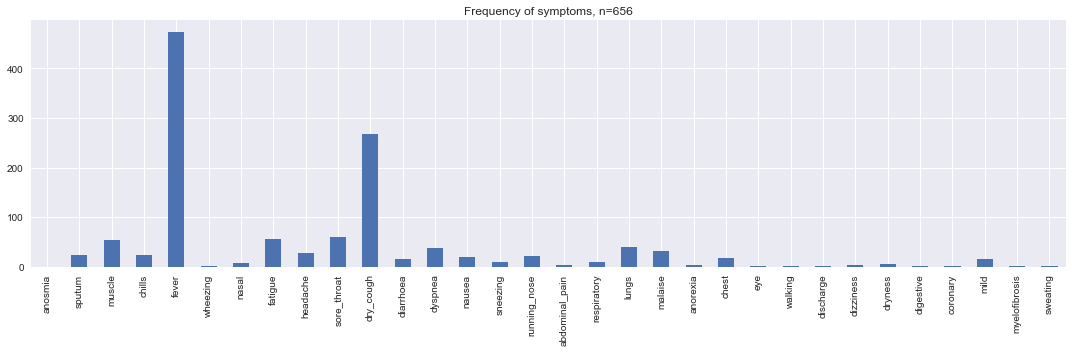

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

v = [d[d[c] == 1].shape[0] for c in d.columns]
s = pd.Series(v, d.columns)

fig, ax = plt.subplots(figsize=(15, 5))
_ = s.plot(kind='bar', ax=ax, title=f'Frequency of symptoms, n={d.shape[0]}')

plt.tight_layout()

## Bayesian Belief Network

The BBN structure is a result of assuming independence between the symptoms, and we know this assumption is wrong. However, we know that if we do not assume independence between the symptoms, there are more parameters to estimate and/or provide. As for the parameters, according to the original authors of this BBN, the parameters are taken from a variety of sources. 

The following are the variables (or nodes) in the BBN.

* anosmia
* chills
* diarrhoea
* dry_cough
* dyspnea
* fatigue
* fever
* headache
* muscle
* nasal
* nausea
* running_nose
* sneezing
* sore_throat
* sputum
* wheezing

Note that all these nodes, except `disease` and `flu_shot` are symptoms. 

### BBN structure

In [4]:
from pybbn.graph.dag import Bbn
from pybbn.pptc.inferencecontroller import InferenceController
import json

with open('./covid/naive.json', 'r') as f:
    bbn = Bbn.from_dict(json.load(f))
join_tree = InferenceController.apply(bbn)

The following shows the BBN structure. The `disease` node points to all the symptoms, and the `flu_shot` node points to the `disease` node. The `disease` node has the following values/states.

* no_virus
* rhinovirus
* hmpv (Metapneumovirus)
* hrsv (Respiratory syncytial)
* influenza
* covid19 (COVID-19)

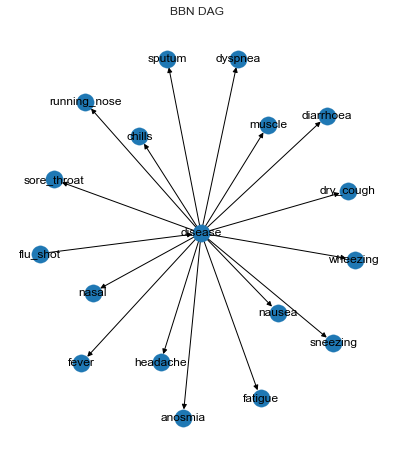

In [5]:
from pybbn.generator.bbngenerator import convert_for_drawing
import networkx as nx
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(15, 8))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')

### BBN Parameters

The following shows the marginal posteriors of the nodes.

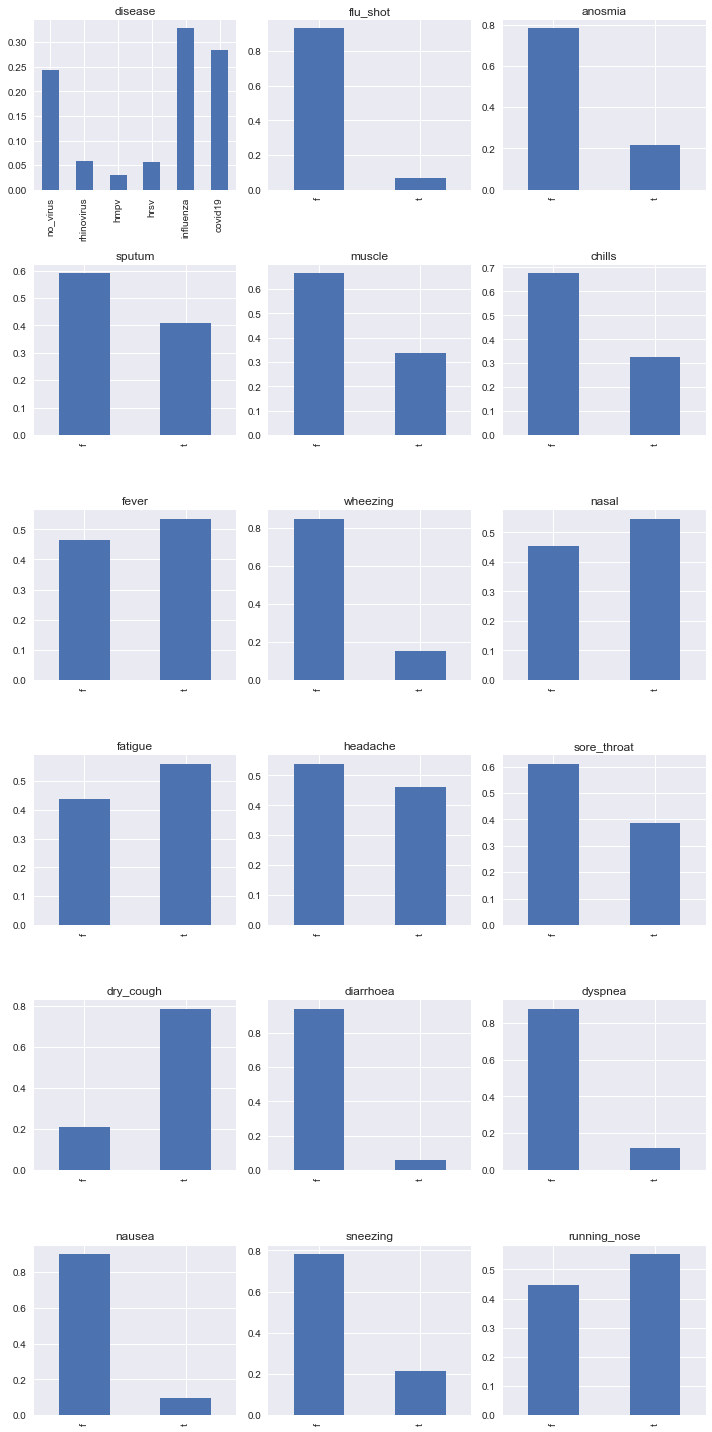

In [6]:
def potential_to_series(potential):
    def get_entry_kv(entry):
        arr = [(k, v) for k, v in entry.entries.items()]
        arr = sorted(arr, key=lambda tup: tup[0])
        return arr[0][1], entry.value
    
    tups = [get_entry_kv(e) for e in potential.entries]
    return pd.Series([tup[1] for tup in tups], [tup[0] for tup in tups])
    
series = [(node, potential_to_series(join_tree.get_bbn_potential(node))) for node in join_tree.get_bbn_nodes()]

n_cols = 3
n_rows = int(len(series) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 20))
axes = np.ravel(axes)

for ax, (node, s) in zip(axes, series):
    s.plot(kind='bar', ax=ax, title=f'{node.variable.name}')

plt.tight_layout()

## Diagnosis

Now we are ready to make diagnosis using the BBN. The total set of symptoms in the Hubei dataset (as we have transformed them) is 32, however, there are only 16 symptoms modeled into the BBN.

In [7]:
%%time

from pybbn.graph.jointree import EvidenceBuilder

names = [
    'anosmia', 'sputum', 'muscle', 'chills', 'fever', 
    'wheezing', 'nasal', 'fatigue', 'headache', 'sore_throat',
    'dry_cough', 'diarrhoea', 'dyspnea', 'nausea', 'sneezing',
    'running_nose'
]

predictions = []

for i, r in d.iterrows():
    fields = [name for name in names if r[name] == 1]
    
    join_tree.unobserve_all()
    
    if len(fields) > 0:
        bbn_nodes = [join_tree.get_bbn_node_by_name(f) for f in fields]
        evidences = [EvidenceBuilder().with_node(n).with_evidence('t', 1.0).build() for n in bbn_nodes]
        join_tree.update_evidences(evidences)
    
    disease = join_tree.get_bbn_node_by_name('disease')
    disease_potential = join_tree.get_bbn_potential(disease)
    s = potential_to_series(disease_potential)
    
    predictions.append(s)

CPU times: user 6.85 s, sys: 40.2 ms, total: 6.89 s
Wall time: 6.93 s


In [8]:
predictions = pd.DataFrame(predictions)
predictions

,no_virus,rhinovirus,hmpv,hrsv,influenza,covid19
0,0.021350,0.011572,0.040865,0.058689,0.465734,0.401790
1,0.194664,0.056940,0.028707,0.085324,0.197598,0.436766
2,0.010166,0.013346,0.032700,0.040446,0.838125,0.065217
3,0.000525,0.017707,0.047804,0.135938,0.748414,0.049613
4,0.194664,0.056940,0.028707,0.085324,0.197598,0.436766
...,...,...,...,...,...,...
651,0.001141,0.020118,0.034012,0.069237,0.875403,0.000089
652,0.242781,0.058875,0.031008,0.055796,0.327462,0.284078
653,0.242781,0.058875,0.031008,0.055796,0.327462,0.284078
654,0.021350,0.011572,0.040865,0.058689,0.465734,0.401790


## Diagnosis Performance

All the records/patients in the Hubei dataset are positively-tested COVID-19 patients. Thus, we have no non-COVID-19 patients, and so we will avoid using performance measures that requires negative examples. 

### Quasi-proper scoring rules

We will try using [average precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) and plot the [precision recall curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html). Note the absurdity of doing so. These performance measures are so-called `quasi-proper scoring rules`.

In [9]:
from sklearn.metrics import average_precision_score

y_true = np.ones(predictions.shape[0])
y_pred = predictions.covid19

ap = average_precision_score(y_true, y_pred)
print(f'average precision score is {ap:.5f}')

average precision score is 1.00000


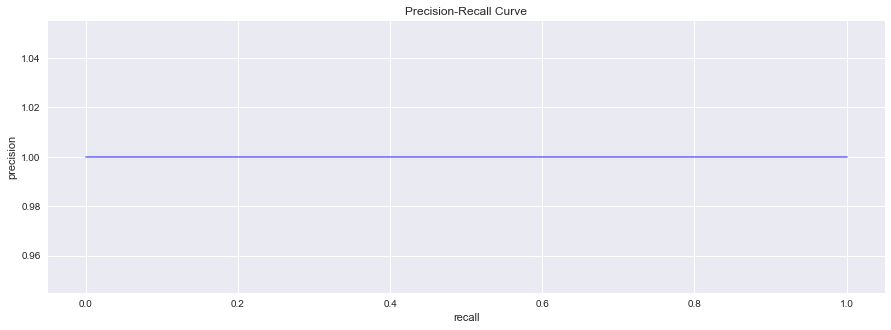

In [10]:
from sklearn.metrics import precision_recall_curve

pre, rec, _ = precision_recall_curve(y_true, y_pred)

fig, ax = plt.subplots(figsize=(15, 5))

_ = ax.step(rec, pre, color='b', alpha=0.5, where='post', label='PR curve')
_ = ax.set_xlabel('recall')
_ = ax.set_ylabel('precision')
_ = ax.set_title('Precision-Recall Curve')

### Proper scoring rule

Instead, we use a `proper scoring rule` such as the [Brier loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss). The Brier score is in the range $[0, 1]$, where a value closer to 0 is better. The Brier score essentially is the mean squared difference between the real probability and predicted one. As you can see, the Brier score is about 0.49. Is this value good or bad? It is right smack in the middle; meaning, it is not un-useful, but could be. 

In [11]:
from sklearn.metrics import brier_score_loss

bsl = brier_score_loss(y_true, y_pred)
print(f'brier score loss = {bsl:.5f}')

brier score loss = 0.48920


### Agreement

Here, we take a different approach to judging the BBN's diagnostic reliability by looking at the counts of predicted patients to have COVID-19 versus the empirical counts. 

* First, we create strata based on the observed and unique combinations of symptoms and observe the empirical number of patients with such co-symptoms. 
* Second, for each unique combination of symptoms observed, we present such symptoms as evidence to the model and allow it to give us the probability of having COVID-19. 
* Third, we multiply the probability by the total number of patients observed across all the strata. 
* Lastly, we compare the `agreement` between the numbers predicted by the BBN and the empirical ones. 

In [12]:
def get_symptom_combinations(r):
    fields = sorted([name for name in names if r[name] == 1])
    return fields

def get_query(combination):
    p_tokens = combination.split(',')
    n_tokens = [n for n in names if n not in p_tokens]
    
    p_tokens = [f'{t}==1' for t in p_tokens]
    n_tokens = [f'{t}==0' for t in n_tokens]
    
    tokens = p_tokens + n_tokens
    query = ' and '.join(tokens)
    return query
    
combinations = [get_symptom_combinations(r) for _, r in d.iterrows()]
combinations = [c for c in combinations if len(c) > 0]
combinations = [','.join(c) for c in combinations]
combinations = sorted(list(set(combinations)))
print(f'number of combinations {len(combinations)}')

queries = [get_query(c) for c in combinations]

# we lose 67 patients, they have no symptoms
strata = pd.DataFrame([(c, d.query(q).shape[0]) for c, q in zip(combinations, queries)], columns=['stratum', 'n'])
strata['n_symptoms'] = strata.stratum.apply(lambda s: len(s.split(',')))
print(f'number of patients {strata.n.sum()}')

number of combinations 103
number of patients 589


This is the distribution of the unique combinations of co-symptoms. Note that some symptoms may show up only by themselves.

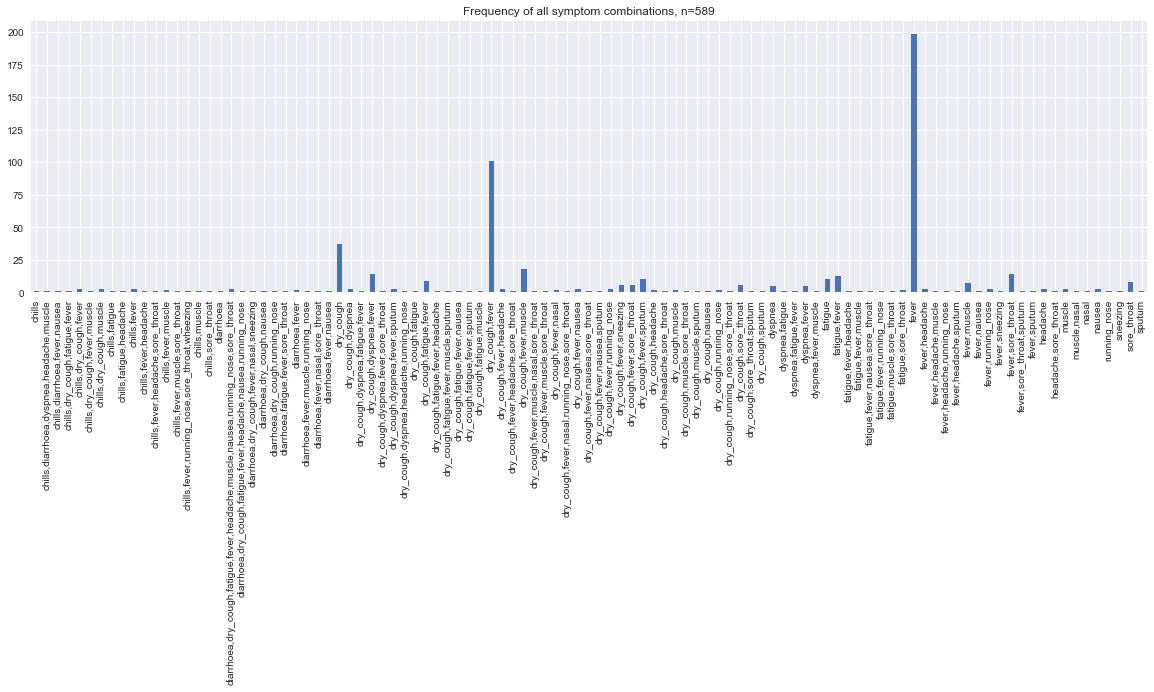

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
s = pd.Series(strata.n.values, strata.stratum.values)
_ = s.plot(kind='bar', ax=ax, title=f'Frequency of all symptom combinations, n={strata.n.sum()}')

In this graph, we remove strata that have only 1 symptom to remove the effect of visual skewness.

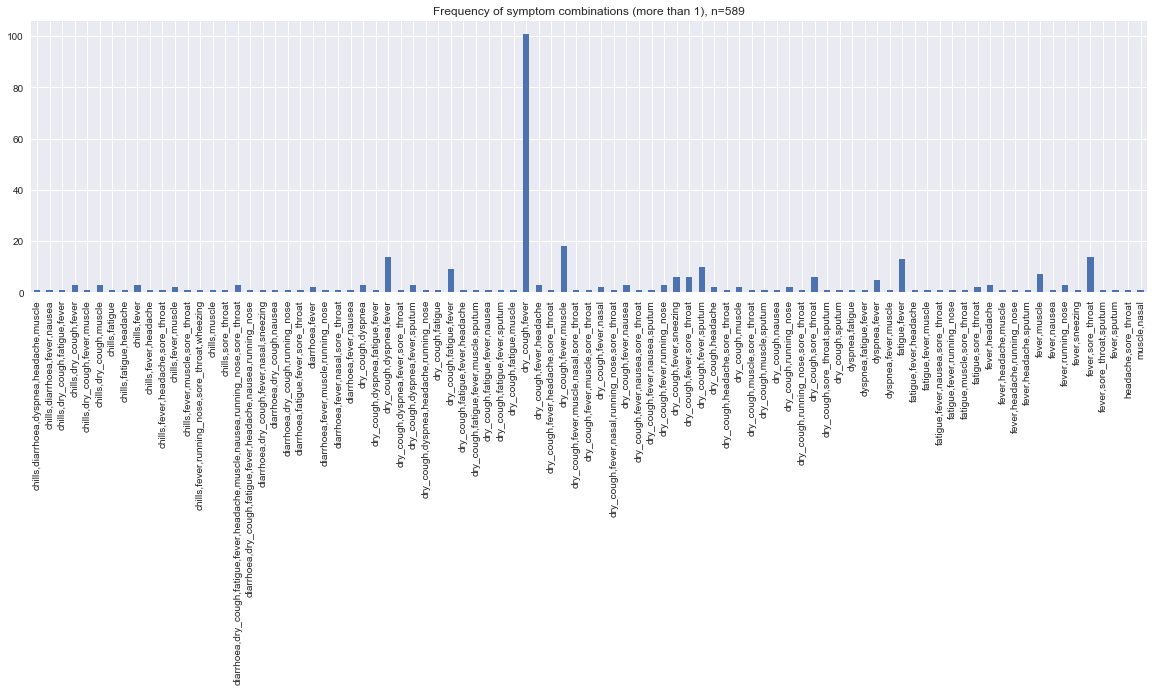

In [14]:
s = strata[strata.n_symptoms > 1]

fig, ax = plt.subplots(figsize=(20, 5))
s = pd.Series(s.n.values, s.stratum.values)
_ = s.plot(kind='bar', ax=ax, title=f'Frequency of symptom combinations (more than 1), n={strata.n.sum()}')

Now we feed the symptoms in each of the stratum to the BBN and estimate the predicted counts of patients with COVID-19.

In [15]:
import math

predictions = []

for i, r in strata.iterrows():
    fields = r.stratum.split(',')
    
    join_tree.unobserve_all()
    
    if len(fields) > 0:
        bbn_nodes = [join_tree.get_bbn_node_by_name(f) for f in fields]
        evidences = [EvidenceBuilder().with_node(n).with_evidence('t', 1.0).build() for n in bbn_nodes]
        join_tree.update_evidences(evidences)
    
    disease = join_tree.get_bbn_node_by_name('disease')
    disease_potential = join_tree.get_bbn_potential(disease)
    s = potential_to_series(disease_potential)
    
    predictions.append(s)
    
predictions = pd.DataFrame(predictions)

n = strata.n.sum()
preds = pd.DataFrame([(math.ceil(n * p), c) for p, c in zip(predictions.covid19, strata.n)], columns=['y_pred', 'y_true'])

Below, we visualize the predicted number of patients with COVID-19 given multiple symptoms with the model versus the empirical numbers. We use [Pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html), [Kendall](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html), and [Spearman](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html) correlations. The latter two correlation measures are rank correlations and may be used to gauge at the agreement between the ranked predicted and empirical frequencies/counts. For all these correlation measures, the higher the value, the better the agreement. As can be seen below, there is positive agreement, and in some sense, especially with `Spearman correlation`, the agreement is strong.

Let's note that the few dots to the right correspond to stratum with a single symptom. This observation is not surprising, since the BBN assumes independence between the symptoms; meaning, we should expect agreement between the predicted and empirical counts when it comes to stratum with one symptom. 

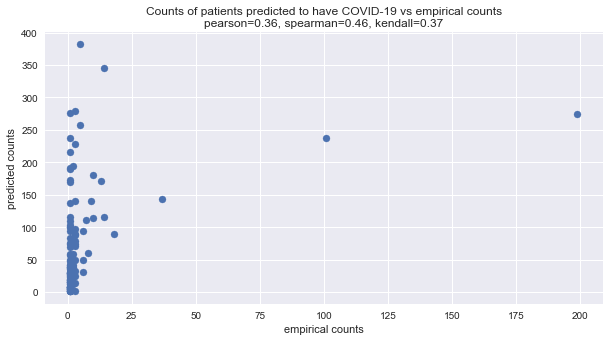

In [16]:
from scipy.stats import spearmanr, kendalltau, pearsonr

spearman = spearmanr(preds.y_true, preds.y_pred).correlation
kendall = kendalltau(preds.y_true, preds.y_pred).correlation
pearson = pearsonr(preds.y_true, preds.y_pred)[0]

fig, ax = plt.subplots(figsize=(10, 5))

_ = ax.scatter(preds.y_true, preds.y_pred)
_ = ax.set_title(f'Counts of patients predicted to have COVID-19 vs empirical counts\npearson={pearson:.2f}, spearman={spearman:.2f}, kendall={kendall:.2f}')
_ = ax.set_xlabel('empirical counts')
_ = ax.set_ylabel('predicted counts')

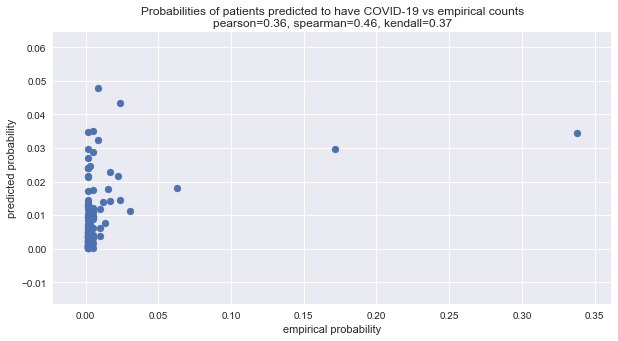

In [17]:
x = preds / preds.sum()

spearman = spearmanr(x.y_true, x.y_pred).correlation
kendall = kendalltau(x.y_true, x.y_pred).correlation
pearson = pearsonr(x.y_true, x.y_pred)[0]

fig, ax = plt.subplots(figsize=(10, 5))

_ = ax.scatter(x.y_true, x.y_pred)
_ = ax.set_title(f'Probabilities of patients predicted to have COVID-19 vs empirical counts\npearson={pearson:.2f}, spearman={spearman:.2f}, kendall={kendall:.2f}')
_ = ax.set_xlabel('empirical probability')
_ = ax.set_ylabel('predicted probability')

Here is the mean squared difference between the predicted probabilities (of frequencies) and the empirical ones. Wow! Almost zero!

In [18]:
x.apply(lambda r: (r.y_pred - r.y_true)**2, axis=1).mean()

0.0012162588488363877

Here is the Brier score for the predicted probabilities. Remember, Brier loss ranges from $[0, 1]$ and the lower the Brier loss, the better. This approach of judging the BBN means that the model is very bad at diagnosing COVID-19.

In [19]:
brier_score_loss(np.ones(x.shape[0]), x.y_pred)

0.9807848118843429

Here is the Brier score for the empirical probabilities. Whew! These two last results suggest maybe this way of judging the BBN is not correct.

In [20]:
brier_score_loss(np.ones(x.shape[0]), x.y_true)

0.9820609112681514

## Misc

Ignore the code below. It will print out all the unique symptoms in the Hubei data. Useful for the symptom mapping exercise.

In [21]:
# x = [tokenize(s) for s in data.symptoms if s is not None]
# x = [tokens for tokens in x if tokens is not None and len(tokens) > 0]
# n = len(x)
# x = list(itertools.chain(*[item for item in x]))
# for i, s in enumerate(sorted(list(set(x)))):
#     print(f'{i}, {s}')